In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [ ]:
# Data directory
DATADIR = '/content/drive/My Drive/Human Activity Recognition/HAR/UCI_HAR_Dataset'

In [ ]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [ ]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/Human Activity Recognition/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [ ]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/Human Activity Recognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [ ]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [ ]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [ ]:
# Configuring a session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [ ]:
# Import Keras
import tensorflow.keras.backend as K
sess =tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

AttributeError: ignored

In [ ]:
# Importing libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [ ]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [ ]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [ ]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
print(len(X_test))

128
9
7352
2947


In [ ]:
print('Train Data Shape',X_train.shape)
print('Test Data Shape',X_test.shape)

Train Data Shape (7352, 128, 9)
Test Data Shape (2947, 128, 9)


#  Defining the Architecture of LSTM

### MODEL 1 : 1 layer LSTM + 32 hidden units + 0.5 dropout + rmsprop

In [ ]:
# Initiliazing the sequential model with 32 units
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5376      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 12s 2ms/sample - loss: 1.2162 - acc: 0.5200 - val_loss: 0.9938 - val_acc: 0.5918
Epoch 2/30
7352/7352 [==============================] - 13s 2ms/sample - loss: 0.8531 - acc: 0.6270 - val_loss: 0.7971 - val_acc: 0.6315
Epoch 3/30
7352/7352 [==============================] - 12s 2ms/sample - loss: 0.8155 - acc: 0.6473 - val_loss: 0.7995 - val_acc: 0.6563
Epoch 4/30
7352/7352 [==============================] - 12s 2ms/sample - loss: 0.6661 - acc: 0.7129 - val_loss: 0.7254 - val_acc: 0.7119
Epoch 5/30
7352/7352 [==============================] - 13s 2ms/sample - loss: 0.5696 - acc: 0.7695 - val_loss: 0.6276 - val_acc: 0.7391
Epoch 6/30
7352/7352 [==============================] - 13s 2ms/sample - loss: 0.4844 - acc: 0.7881 - val_loss: 0.5341 - val_acc: 0.7438
Epoch 7/30
7352/7352 [==============================] - 13s 2ms/sample - loss: 0.4248 - acc: 0.8113 - val_loss: 0.4456 - val_acc: 

In [ ]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 513        0  ...                   0                 0
SITTING                  0      380  ...                   0                 4
STANDING                 0       84  ...                   0                 0
WALKING                  0        0  ...                  10                32
WALKING_DOWNSTAIRS       0        0  ...                 414                 6
WALKING_UPSTAIRS         0        7  ...                  10               452

[6 rows x 6 columns]


In [ ]:
score = model.evaluate(X_test, Y_test)

In [ ]:
score

[0.3225987807939674, 0.90295213]

- With a 1 layer architecture (32 units and 0.5 dropout rates) we got 90.29% accuracy and a loss of 0.32


###MODEL 2: 1 layer LSTM + 64 hidden units + 0.25 dropout + adam

In [ ]:
# Initiliazing the sequential model with 64 units
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 18s 2ms/sample - loss: 1.1284 - acc: 0.5292 - val_loss: 0.8816 - val_acc: 0.6641
Epoch 2/30
7352/7352 [==============================] - 18s 2ms/sample - loss: 0.8221 - acc: 0.6628 - val_loss: 0.8014 - val_acc: 0.6953
Epoch 3/30
7352/7352 [==============================] - 18s 2ms/sample - loss: 0.6092 - acc: 0.7599 - val_loss: 0.6947 - val_acc: 0.7340
Epoch 4/30
7352/7352 [==============================] - 18s 2ms/sample - loss: 0.4795 - acc: 0.8138 - val_loss: 0.5723 - val_acc: 0.8140
Epoch 5/30
7352/7352 [==============================] - 18s 2ms/sample - loss: 0.3611 - acc: 0.8849 - val_loss: 0.5265 - val_acc: 0.8171
Epoch 6/30
7352/7352 [==============================] - 18s 2ms/sample - loss: 0.2388 - acc: 0.9177 - val_loss: 0.4205 - val_acc: 0.8721
Epoch 7/30
7352/7352 [==============================] - 18s 3ms/sample - loss: 0.2010 - acc: 0.9312 - val_loss: 0.4697 - val_acc: 

In [ ]:
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                 2
SITTING                  0      417  ...                   1                 8
STANDING                 0      110  ...                   0                 2
WALKING                  0        0  ...                  14                 0
WALKING_DOWNSTAIRS       0        0  ...                 414                 1
WALKING_UPSTAIRS         0        0  ...                   1               448

[6 rows x 6 columns]


In [ ]:
score = model.evaluate(X_test, Y_test)

In [ ]:
score

[0.3598927074421736, 0.9127927]

###MODEL 3 : 2 layer LSTM + 100 hidden units + 0.5 dropout + adam

In [ ]:
n_hidden2 = 100

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(n_hidden2, return_sequences=True, input_shape=(timesteps, input_dim)))
model_2.add(Dropout(0.5))
model_2.add(LSTM(n_hidden2))
model_2.add(Dropout(0.5))
model_2.add(Dense(n_classes, activation='sigmoid'))
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 100)          44000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 606       
Total params: 125,006
Trainable params: 125,006
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the model
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Training the model
model_2.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 63s 9ms/sample - loss: 1.2670 - acc: 0.4374 - val_loss: 1.3001 - val_acc: 0.4238
Epoch 2/30
7352/7352 [==============================] - 64s 9ms/sample - loss: 1.3861 - acc: 0.3721 - val_loss: 1.4212 - val_acc: 0.3400
Epoch 3/30
7352/7352 [==============================] - 64s 9ms/sample - loss: 1.3230 - acc: 0.4093 - val_loss: 1.1213 - val_acc: 0.4595
Epoch 4/30
7352/7352 [==============================] - 63s 9ms/sample - loss: 1.4234 - acc: 0.3516 - val_loss: 1.4555 - val_acc: 0.3288
Epoch 5/30
7352/7352 [==============================] - 64s 9ms/sample - loss: 1.4096 - acc: 0.3598 - val_loss: 1.4732 - val_acc: 0.3180
Epoch 6/30
7352/7352 [==============================] - 64s 9ms/sample - loss: 1.3084 - acc: 0.4188 - val_loss: 1.1213 - val_acc: 0.5409
Epoch 7/30
7352/7352 [==============================] - 69s 9ms/sample - loss: 1.3130 - acc: 0.4241 - val_loss: 1.2175 - val_acc: 

In [ ]:
score_2 = model_2.evaluate(X_test, Y_test)
print(score_2)

[0.3598927074421736, 0.9127927]


In [ ]:
print(confusion_matrix(Y_test, model_2.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  0      419  ...                   0                 7
STANDING                 0      127  ...                   0                 0
WALKING                  0        0  ...                  19                 3
WALKING_DOWNSTAIRS       0        0  ...                 415                 2
WALKING_UPSTAIRS         0        0  ...                  19               427

[6 rows x 6 columns]


###MODEL 4 : 3 layer LSTM + 64 hidden units + 0.5 dropout + adam

In [ ]:
n_hidden3 = 64
model_3 = Sequential()
model_3.add(LSTM(n_hidden3, return_sequences=True, input_shape=(timesteps, input_dim)))
model_3.add(Dropout(0.5))
model_3.add(LSTM(n_hidden3, return_sequences=True))
model_3.add(Dropout(0.5))
model_3.add(LSTM(n_hidden3))
model_3.add(Dropout(0.5))
model_3.add(Dense(n_classes, activation='sigmoid'))
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 128, 64)           33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

In [ ]:
# Compiling the model
model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Training the model
model_3.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 65s 9ms/sample - loss: 1.1274 - acc: 0.5083 - val_loss: 1.5227 - val_acc: 0.3332
Epoch 2/30
7352/7352 [==============================] - 66s 9ms/sample - loss: 1.3898 - acc: 0.3541 - val_loss: 1.4192 - val_acc: 0.3414
Epoch 3/30
7352/7352 [==============================] - 69s 9ms/sample - loss: 1.3766 - acc: 0.3607 - val_loss: 1.4178 - val_acc: 0.3414
Epoch 4/30
7352/7352 [==============================] - 66s 9ms/sample - loss: 1.3763 - acc: 0.3614 - val_loss: 1.4172 - val_acc: 0.3414
Epoch 5/30
7352/7352 [==============================] - 67s 9ms/sample - loss: 1.3708 - acc: 0.3675 - val_loss: 1.4127 - val_acc: 0.3434
Epoch 6/30
7352/7352 [==============================] - 67s 9ms/sample - loss: 1.3740 - acc: 0.3624 - val_loss: 1.4136 - val_acc: 0.3431
Epoch 7/30
7352/7352 [==============================] - 66s 9ms/sample - loss: 1.3729 - acc: 0.3664 - val_loss: 1.3862 - val_acc: 

In [ ]:
scores_3 = model_3.evaluate(X_test, Y_test)
print(scores_3)

[0.5835877889719886, 0.7285375]


In [ ]:
print(confusion_matrix(Y_test, model_3.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        2  ...                   0                 0
SITTING                  0      444  ...                   0                 0
STANDING                 0      140  ...                   0                 0
WALKING                  0        0  ...                   0                 0
WALKING_DOWNSTAIRS       0        0  ...                   2               386
WALKING_UPSTAIRS         0        0  ...                   0               304

[6 rows x 6 columns]


### Model 5 : 1 layer LSTM + 32 hidden units + 0.5 dropout + Adam 

In [ ]:
model_5 = Sequential()
model_5.add(LSTM(32, input_shape = (timesteps, input_dim)))
model_5.add(Dropout(0.5))
model_5.add(Dense(n_classes, activation='sigmoid'))
model_5.summary()

model_5.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_5.fit(X_train,Y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, Y_test))



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
460/460 [==============================] - 17s 37ms/step - loss: 1.2714 - accuracy: 0.4829 - val_loss: 0.9929 - val_accuracy: 0.6047
Epoch 2/30
460/460 [==============================] - 17s 37ms/step - loss: 0.9292 - accuracy: 0.6099 - val_loss: 1.1225 - val_accuracy: 0.5636
Epoch 3/30
460/460 [==============================] - 17s 37ms/step - loss: 0.9420 - accuracy:

In [ ]:
scores_5 = model_5.evaluate(X_test,Y_test,verbose = 1)
test5_score = scores_5[0]
test5_acc = scores_5[1]

print("Test Score Model 5 : ", test5_score)
print("Test Accuracy Model 5 : ", test5_acc)


93/93 [==============================] - 1s 8ms/step - loss: 0.3122 - accuracy: 0.8951
Test Score Model 5 :  0.3121752440929413
Test Accuracy Model 5 :  0.8951476216316223


### Model 6 : 1 layer LSTM + 64 hidden units + 0.75 dropout + Rmsprop

In [ ]:
model_6 = Sequential()
model_6.add(LSTM(64, input_shape = (timesteps, input_dim)))
model_6.add(Dropout(0.75))
model_6.add(Dense(n_classes, activation='sigmoid'))
model_6.summary()

model_6.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model_6_res = model_6.fit(X_train,Y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, Y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                18944     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
460/460 [==============================] - 23s 50ms/step - loss: 1.3397 - accuracy: 0.4192 - val_loss: 1.1674 - val_accuracy: 0.4852
Epoch 2/30
460/460 [==============================] - 24s 51ms/step - loss: 1.0910 - accuracy: 0.5121 - val_loss: 0.9683 - val_accuracy: 0.5901
Epoch 3/30
460/460 [==============================] - 23s 50ms/step - loss: 0.9138 - accuracy:

In [ ]:
scores_6 = model_6.evaluate(X_test,Y_test,verbose = 1)
test6_score = scores_6[0]
test6_acc = scores_6[1]

print("Test Score Model 6 : ", test6_score)
print("Test Accuracy Model 6 : ", test6_acc)

93/93 [==============================] - 2s 17ms/step - loss: 0.4127 - accuracy: 0.9121
Test Score Model 6 :  0.41273969411849976
Test Accuracy Model 6 :  0.9121140241622925


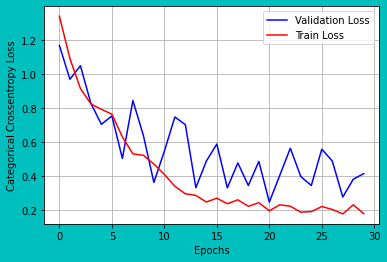

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time


fig = plt.figure( facecolor='c', edgecolor='k')
plt.plot( model_6_res.history['val_loss'], 'b', label="Validation Loss")
plt.plot( model_6_res.history['loss'], 'r', label="Train Loss")
plt.xlabel('Epochs') 
plt.ylabel('Categorical Crossentropy Loss')
plt.legend()
plt.grid()
plt.show()

### Model 7 : 2 layer LSTM + 64 hidden units + 0.5 dropout + Adam

In [ ]:
model_7 = Sequential()
model_7.add(LSTM(64, return_sequences = True, input_shape = (timesteps, input_dim)))
model_7.add(Dropout(0.5))
model_7.add(LSTM(64))
model_7.add(Dropout(0.5))
model_7.add(Dense(n_classes, activation='sigmoid'))
model_7.summary()

model_7.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_7_res = model_7.fit(X_train,Y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, Y_test))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
460/460 [==============================] - 48s 105ms/step - loss: 1.2740 - accuracy: 0.4533 - val_loss: 1

93/93 [==============================] - 3s 32ms/step - loss: 0.3980 - accuracy: 0.8921
Test Score Model 7 :  0.3980039358139038
Test Accuracy Model 7 :  0.8920936584472656


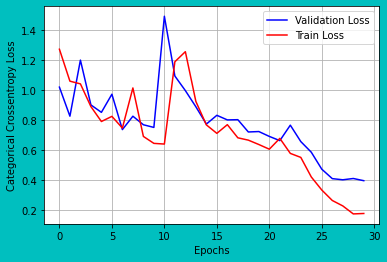

In [ ]:
scores_7 = model_7.evaluate(X_test,Y_test,verbose = 1)
test7_score = scores_7[0]
test7_acc = scores_7[1]

print("Test Score Model 7 : ", test7_score)
print("Test Accuracy Model 7 : ", test7_acc)

fig = plt.figure( facecolor='c', edgecolor='k')
plt.plot( model_7_res.history['val_loss'], 'b', label="Validation Loss")
plt.plot( model_7_res.history['loss'], 'r', label="Train Loss")
plt.xlabel('Epochs') 
plt.ylabel('Categorical Crossentropy Loss')
plt.legend()
plt.grid()
plt.show()

### Model 8 : 2 layer LSTM + 150 hidden units + 0.5 dropout + Adam

In [ ]:
model_8 = Sequential()
model_8.add(LSTM(150, return_sequences = True, input_shape = (timesteps, input_dim)))
model_8.add(Dropout(0.5))
model_8.add(LSTM(150))
model_8.add(Dropout(0.5))
model_8.add(Dense(n_classes, activation='sigmoid'))
model_8.summary()

model_8.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_8_res = model_8.fit(X_train,Y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, Y_test))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128, 150)          96000     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 150)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dropout_7 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 906       
Total params: 277,506
Trainable params: 277,506
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
460/460 [==============================] - 110s 239ms/step - loss: 1.3519 - accuracy: 0.3980 - val_loss

93/93 [==============================] - 7s 75ms/step - loss: 0.2744 - accuracy: 0.9182
Test Score Model 8 :  0.2743934988975525
Test Accuracy Model 8 :  0.9182218909263611


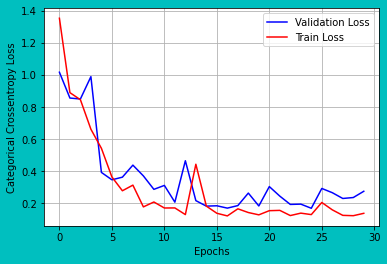

In [ ]:
scores_8 = model_8.evaluate(X_test,Y_test,verbose = 1)
test8_score = scores_8[0]
test8_acc = scores_8[1]

print("Test Score Model 8 : ", test8_score)
print("Test Accuracy Model 8 : ", test8_acc)

fig = plt.figure( facecolor='c', edgecolor='k')
plt.plot( model_8_res.history['val_loss'], 'b', label="Validation Loss")
plt.plot( model_8_res.history['loss'], 'r', label="Train Loss")
plt.xlabel('Epochs') 
plt.ylabel('Categorical Crossentropy Loss')
plt.legend()
plt.grid()
plt.show()

### Model 9 : 2 layers LSTM + 200 hidden units + 0.5 dropout + Adam

In [ ]:
model_9 = Sequential()
model_9.add(LSTM(200, return_sequences = True, input_shape = (timesteps, input_dim)))
model_9.add(Dropout(0.5))
model_9.add(LSTM(200))
model_9.add(Dropout(0.5))
model_9.add(Dense(n_classes, activation='sigmoid'))
model_9.summary()

model_9.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_9_res = model_9.fit(X_train,Y_train, epochs = epochs, batch_size = batch_size, validation_data = (X_test, Y_test))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128, 200)          168000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128, 200)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1206      
Total params: 490,006
Trainable params: 490,006
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
460/460 [==============================] - 191s 416ms/step - loss: 1.2529 - accuracy: 0.4353 - val_loss

93/93 [==============================] - 14s 151ms/step - loss: 1.7839 - accuracy: 0.1822
Test Score Model 9 :  1.7838802337646484
Test Accuracy Model 9 :  0.18221920728683472


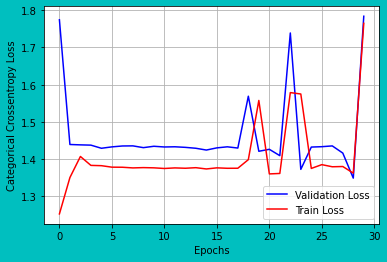

In [ ]:
scores_9 = model_9.evaluate(X_test,Y_test,verbose = 1)
test9_score = scores_9[0]
test9_acc = scores_9[1]

print("Test Score Model 9 : ", test9_score)
print("Test Accuracy Model 9 : ", test9_acc)

fig = plt.figure( facecolor='c', edgecolor='k')
plt.plot( model_9_res.history['val_loss'], 'b', label="Validation Loss")
plt.plot( model_9_res.history['loss'], 'r', label="Train Loss")
plt.xlabel('Epochs') 
plt.ylabel('Categorical Crossentropy Loss')
plt.legend()
plt.grid()
plt.show()

#### Divide and Conquer Method :

In [ ]:

# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,BatchNormalization,Conv2D,Flatten,TimeDistributed,Conv1D,MaxPool1D
from keras.regularizers import *
from keras.callbacks import LearningRateScheduler,TerminateOnNaN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.initializers import VarianceScaling
from keras.optimizers import *

##### Model 1 : Binary Classifier to classify Static and Dynamic Classes :

In [ ]:
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/Human Activity Recognition/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [ ]:

def load_y_binary(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/Human Activity Recognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    #print(y)
    y[y<4] = 0
    y[y>3] = 1
    #print(y)
    return pd.get_dummies(y).to_numpy()

def load_data_binary():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train,y_test = load_y_binary('train'),load_y_binary("test")
    return X_train, X_test, y_train, y_test

In [ ]:
X_Train_binary,X_Test_binary, Y_Train_binary, Y_Test_binary = load_data_binary()

In [ ]:
timesteps = len(X_Train_binary[0])
input_dim = len(X_Train_binary[0][0])
print("Timesteps : ", timesteps)
print('Input Dimension : ', input_dim)
print("Train Shape : ", X_Train_binary.shape)
print("Test Shape : ", X_Test_binary.shape)


Timesteps :  128
Input Dimension :  9
Train Shape :  (7352, 128, 9)
Test Shape :  (2947, 128, 9)


In [ ]:
#Architecture :

model_1stStage_binary = Sequential()
model_1stStage_binary.add(Conv1D(32, kernel_size = 3, kernel_initializer= 'glorot_normal',activation='relu',kernel_regularizer = l2(0.003), input_shape = (timesteps,input_dim)))
#model_1stStage_binary.add(MaxPool1D(2))
model_1stStage_binary.add(Conv1D(32, kernel_size= 3, kernel_initializer='glorot_normal',activation='relu',kernel_regularizer = l2(0.003)))
model_1stStage_binary.add(Dropout(0.6))
model_1stStage_binary.add(MaxPool1D(2))
model_1stStage_binary.add(Flatten())
model_1stStage_binary.add(Dense(64, activation='relu'))
model_1stStage_binary.add(Dropout(0.5))
model_1stStage_binary.add(Dense(2, activation='softmax'))
model_1stStage_binary.summary()

model_1stStage_binary.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

result_1stStage_binary = model_1stStage_binary.fit(X_Train_binary,Y_Train_binary, batch_size = 64, epochs = epochs, validation_data = (X_Test_binary,Y_Test_binary), verbose = 1)


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 126, 32)           896       
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 124, 32)           3104      
_________________________________________________________________
dropout_46 (Dropout)         (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 62, 32)            0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1984)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                127040    
_________________________________________________________________
dropout_47 (Dropout)         (None, 64)              

In [ ]:
model_1stStage_binary.evaluate(X_Test_binary,Y_Test_binary)

93/93 [==============================] - 0s 3ms/step - loss: 0.0092 - accuracy: 0.9983


[0.009171461686491966, 0.9983033537864685]

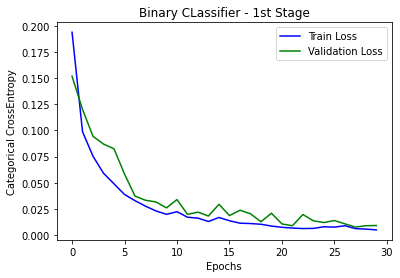

In [ ]:
train_loss_1stStage_binary = result_1stStage_binary.history['loss']
val_loss_1stStage_binary = result_1stStage_binary.history['val_loss']

#Plotting the loss
plt.plot(train_loss_1stStage_binary , 'b', label="Train Loss" )
plt.plot(val_loss_1stStage_binary , 'g', label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Categorical CrossEntropy')
plt.title('Binary CLassifier - 1st Stage')
plt.legend()
plt.show()

In [ ]:
model_1stStage_binary.save('/content/drive/My Drive/Human Activity Recognition/HAR/Model_1stStage_Binary.h5')

##### Model 2 : Classifier for Only Static Classes :

In [ ]:
def load_y_static(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/Human Activity Recognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    #Getting the boolean values for this condition. These boolean values are later used to get the X records corresponding to these Y.
    class_y = y>3
    new_y = y[class_y]
    return pd.get_dummies(new_y).to_numpy(),class_y

def load_data_static():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train_new, y_label_train = load_y_static('train')
    y_val_new,y_label_test = load_y_static('test')
    X_train_new = X_train[y_label_train]
    X_val_new = X_test[y_label_test]
    return X_train_new, X_val_new, y_train_new, y_val_new

In [ ]:
X_Train_static , X_Test_static, Y_Train_static , Y_Test_static = load_data_static()

In [ ]:
print('Timesteps : ', len(X_Train_static[0]))
print("Input Dimension for Static Classifier : ", len(X_Train_static[0][0]))
print('Train Shape : ', X_Train_static.shape)
print("Test Shape : ", X_Test_static.shape)

Timesteps :  128
Input Dimension for Static Classifier :  9
Train Shape :  (4067, 128, 9)
Test Shape :  (1560, 128, 9)


In [ ]:
custom_adam = Adam(learning_rate=0.0001)

In [ ]:
%%time
model_2ndStage_static = Sequential()
model_2ndStage_static.add(Conv1D(30,kernel_size= 3, activation='relu', input_shape = (timesteps,input_dim), kernel_initializer= 'glorot_normal',kernel_regularizer = l2(0.003)))
model_2ndStage_static.add(BatchNormalization())
model_2ndStage_static.add(Dropout(0.7))
model_2ndStage_static.add(Conv1D(50, kernel_size= 3, activation='relu', kernel_initializer='glorot_normal',kernel_regularizer = l2(0.003)))
model_2ndStage_static.add(BatchNormalization())
model_2ndStage_static.add(Dropout(0.5))
model_2ndStage_static.add(Conv1D(100, kernel_size= 3, activation='relu', kernel_initializer='glorot_normal',kernel_regularizer = l2(0.003)))
model_2ndStage_static.add(BatchNormalization())
model_2ndStage_static.add(Dropout(0.4))
model_2ndStage_static.add(Flatten())
model_2ndStage_static.add(Dense(100, activation='relu'))
model_2ndStage_static.add(Dropout(0.5))
model_2ndStage_static.add(Dense(3, activation='softmax'))
model_2ndStage_static.summary()

model_2ndStage_static.compile(loss = 'categorical_crossentropy', optimizer = custom_adam, metrics = ['accuracy'])

result_2ndStatge_static = model_2ndStage_static.fit(X_Train_static,Y_Train_static, 
                                                    batch_size = 32, epochs = 40, validation_data = (X_Test_static,Y_Test_static))

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 126, 30)           840       
_________________________________________________________________
batch_normalization_11 (Batc (None, 126, 30)           120       
_________________________________________________________________
dropout_48 (Dropout)         (None, 126, 30)           0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 124, 50)           4550      
_________________________________________________________________
batch_normalization_12 (Batc (None, 124, 50)           200       
_________________________________________________________________
dropout_49 (Dropout)         (None, 124, 50)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 122, 100)        

In [ ]:
model_2ndStage_static.evaluate(X_Test_static,Y_Test_static)

49/49 [==============================] - 0s 9ms/step - loss: 0.5600 - accuracy: 0.8897


[0.5600143671035767, 0.8897435665130615]

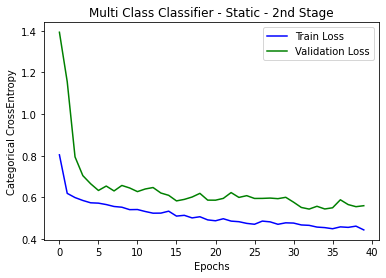

In [ ]:
train_loss_2stStage_static = result_2ndStatge_static.history['loss']
val_loss_2stStage_static = result_2ndStatge_static.history['val_loss']

#Plotting the loss
plt.plot(train_loss_2stStage_static , 'b', label="Train Loss" )
plt.plot(val_loss_2stStage_static , 'g', label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Categorical CrossEntropy')
plt.title('Multi Class Classifier - Static - 2nd Stage')
plt.legend()
plt.show()

In [ ]:
model_2ndStage_static.save('/content/drive/My Drive/Human Activity Recognition/HAR/Model_2ndStage_Static.h5')

##### Model 3 : Classifier for Dynamic Classes :

In [ ]:
def load_y_dynamic(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/Human Activity Recognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    class_y = y<=3
    new_y = y[class_y]
    return pd.get_dummies(new_y).to_numpy(),class_y

def load_data_dymanic():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train_new, y_label_train = load_y_dynamic('train')
    y_val_new,y_label_test = load_y_dynamic('test')
    X_train_new = X_train[y_label_train]
    X_val_new = X_test[y_label_test]
    return X_train_new, X_val_new, y_train_new, y_val_new

In [ ]:
X_Train_dynamic, X_Test_dynamic, Y_Train_dynamic, Y_Test_dynamic = load_data_dymanic()

In [ ]:
print('Timesteps : ', len(X_Train_dynamic[0]))
print('Input Dimension for Dynamic Class : ', len(X_Train_dynamic[0][0]))
print("Train Shape : ", X_Train_dynamic.shape)
print('Test Shape : ', X_Test_dynamic.shape)

Timesteps :  128
Input Dimension for Dynamic Class :  9
Train Shape :  (3285, 128, 9)
Test Shape :  (1387, 128, 9)


In [ ]:
custom_adam_dynamic = Adam(learning_rate=0.0004)

In [ ]:
%%time
model_2ndStage_dynamic = Sequential()
model_2ndStage_dynamic.add(Conv1D(64, kernel_size= 3, activation='relu', input_shape = (timesteps, input_dim), kernel_initializer='glorot_normal'))
#model_2ndStage_dynamic.add(BatchNormalization())
#model_2ndStage_dynamic.add(Dropout(0.7))
#model_2ndStage_dynamic.add(MaxPool1D(3))
model_2ndStage_dynamic.add(Conv1D(32,kernel_size=3, activation='relu', kernel_initializer='glorot_normal'))
model_2ndStage_dynamic.add(Dropout(0.5))
model_2ndStage_dynamic.add(MaxPool1D(3))
model_2ndStage_dynamic.add(Flatten())
model_2ndStage_dynamic.add(Dense(16, activation='relu'))
model_2ndStage_dynamic.add(Dropout(0.5))
model_2ndStage_dynamic.add(Dense(3, activation='softmax'))
model_2ndStage_dynamic.summary()

model_2ndStage_dynamic.compile(loss='categorical_crossentropy',optimizer=custom_adam_dynamic, metrics=['accuracy'])


result_2ndStatge_dynamic = model_2ndStage_dynamic.fit(X_Train_dynamic,Y_Train_dynamic, 
                                                    batch_size = 32, epochs = 30, validation_data = (X_Test_dynamic,Y_Test_dynamic))

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 126, 64)           1792      
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 124, 32)           6176      
_________________________________________________________________
dropout_62 (Dropout)         (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 41, 32)            0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 1312)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 16)                21008     
_________________________________________________________________
dropout_63 (Dropout)         (None, 16)              

In [ ]:
model_2ndStage_dynamic.evaluate(X_Test_dynamic,Y_Test_dynamic)

44/44 [==============================] - 0s 3ms/step - loss: 0.1784 - accuracy: 0.9661


[0.17837686836719513, 0.9661139249801636]

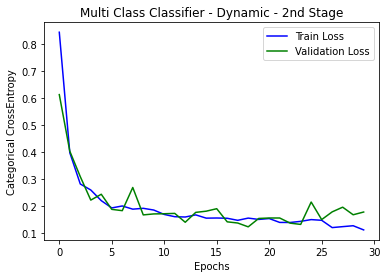

In [ ]:
train_loss_2ndStage_dynamic = result_2ndStatge_dynamic.history['loss']
val_loss_2ndStage_dynamic = result_2ndStatge_dynamic.history['val_loss']

#Plotting the loss
plt.plot(train_loss_2ndStage_dynamic , 'b', label="Train Loss" )
plt.plot(val_loss_2ndStage_dynamic , 'g', label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Categorical CrossEntropy')
plt.title('Multi Class Classifier - Dynamic - 2nd Stage')
plt.legend()
plt.show()

In [ ]:
model_2ndStage_dynamic.save('/content/drive/My Drive/Human Activity Recognition/HAR/Model_2ndStage_Dynamic.h5')

##### Final Model : Stacked all the classifiers :

In [ ]:
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/Human Activity Recognition/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/Human Activity Recognition/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [ ]:
X_Train_final, X_Test_final, Y_Train_final, Y_Test_final = load_data()
print("X train shape :",X_Train_final.shape)
print("X test shape :",X_Test_final.shape)
print("Y train shape :",Y_Train_final.shape)
print("Y train shape :",Y_Test_final.shape)

X train shape : (7352, 128, 9)
X test shape : (2947, 128, 9)
Y train shape : (7352, 6)
Y train shape : (2947, 6)


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from scipy import ndimage

###### Sharpening Test Data with Sigma = 8 and Alpha = 0.07 

In [ ]:
def sharpen_TestData(x_test, sigma, alpha):
    d = x_test.shape[0]
    r = x_test.shape[1]
    c = x_test.shape[2]
    final_sharpened_data = np.empty((d,r, c))
    i = 0

    for row in x_test:
        test = row
        blurred = ndimage.gaussian_filter(test, sigma)
        sharpened = test + alpha * (test - blurred)
        final_sharpened_data[i] = sharpened
        i = i + 1
    return final_sharpened_data

###### Predicting the static and dynamic classes from the Test Data

In [ ]:
Y_Pred_binary = model_1stStage_binary.predict_classes(X_Test_final)

In [ ]:
X_Test_final_static = X_Test_final[Y_Pred_binary>0] # Static Class X
X_Test_final_dynamic = X_Test_final[Y_Pred_binary<1] # Dynamic Class X

In [ ]:
Y_Test_Final_static = Y_Test_final[Y_Pred_binary>0] # Static Class Y
Y_Test_Final_dynamic = Y_Test_final[Y_Pred_binary<1] # Dynamic Class Y

In [ ]:
Y_Test = np.concatenate([Y_Test_Final_static,Y_Test_Final_dynamic]) # FINAL Y_TEST

In [ ]:
X_Test_final_static_sharpen = sharpen_TestData(X_Test_final_static,8,0.07) #Sharpening Test Data X
X_Test_final_dynamic_sharpen = sharpen_TestData(X_Test_final_dynamic,8,0.07) #Sharpening Test Data X

###### Predicting Static Classes using the Model for Static Data CLassification.
Predicting Dynamic Classes using the Model for Dynamic Data Classification.

In [ ]:
Y_Pred_static = model_2ndStage_static.predict_classes(X_Test_final_static_sharpen)+3 #Static
Y_Pred_dynamic = model_2ndStage_dynamic.predict_classes(X_Test_final_dynamic_sharpen) #Dynamic

In [ ]:
Y_Pred = np.concatenate([Y_Pred_static,Y_Pred_dynamic]) #Final Predicted Y

###### Final Accuracy of the Stacked Model of the Divide and Conquer Method :

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
final_accuracy = accuracy_score(np.argmax(Y_Test,axis=1),Y_Pred)
print("Accuracy Using Divide and Conquer Method->",final_accuracy)

Accuracy Using Divide and Conquer Method-> 0.9300984051577876


### FINAL OBSERVATIONS FROM 9 LSTM MODELS BUILT :

In [ ]:
from prettytable import PrettyTable

print('\n')
a = PrettyTable()
a.field_names = ['Model','Optimizer','LSTM Units', 'LSTM Layers', 'Drop Out', 'Test Loss','Test Accuracy (%)']
a.add_row(['Model 1','Rmsprop',32, 1, 0.5, 0.32, 90.2]) 
a.add_row(['Model 2','Adam',64, 1, 0.25, 0.36, 91.2])
a.add_row(['Model 3','Adam',100, 2, 0.5, 0.36, 91.2])
a.add_row(['Model 4','Adam',64, 3, 0.5, 0.59, 72.85])
a.add_row(['Model 5','Adam',32, 1, 0.5, 0.31, 89.5]) 
a.add_row(['Model 6','Rmsprop',64, 1, 0.75, 0.41, 91.2]) 
a.add_row(['Model 7','Adam',64, 2, 0.5, 0.39, 89.2])
a.add_row(['Model 8','Adam',150, 2, 0.5, 0.27, 91.8])
a.add_row(['Model 9','Adam',200, 2, 0.5, 1.78, 18.22])
print(a)



+---------+-----------+------------+-------------+----------+-----------+-------------------+
|  Model  | Optimizer | LSTM Units | LSTM Layers | Drop Out | Test Loss | Test Accuracy (%) |
+---------+-----------+------------+-------------+----------+-----------+-------------------+
| Model 1 |  Rmsprop  |     32     |      1      |   0.5    |    0.32   |        90.2       |
| Model 2 |    Adam   |     64     |      1      |   0.25   |    0.36   |        91.2       |
| Model 3 |    Adam   |    100     |      2      |   0.5    |    0.36   |        91.2       |
| Model 4 |    Adam   |     64     |      3      |   0.5    |    0.59   |       72.85       |
| Model 5 |    Adam   |     32     |      1      |   0.5    |    0.31   |        89.5       |
| Model 6 |  Rmsprop  |     64     |      1      |   0.75   |    0.41   |        91.2       |
| Model 7 |    Adam   |     64     |      2      |   0.5    |    0.39   |        89.2       |
| Model 8 |    Adam   |    150     |      2      |   0.5  

We built 9 models where the best accuracy is 91.8% and the best loss is 0.27 for a 2 layer LSTM with 150 hidden units (Model 8). The worst accuracy came from Model 9 at 18.22%. This model was heavily overfitting with a high loss of 1.78.

We saw as the number of layer increases ( from 2 layers to 3 layers ), the model performance decreases dratically ( Model 4 ). 

### DIVIDE AND CONQUER METHOD OBSERVATIONS :

In [ ]:
print('\n')
a = PrettyTable()
a.field_names = ['Model','Test Accuracy (%)']
a.add_row(['Model 1 - Binary Classification', 99.8033]) 
a.add_row(['Model 2 - Static Classification',88.9743])
a.add_row(['Model 3 - Dynamic Classification', 96.6113])
a.add_row(['Stacked Model', 93.0098])

print(a)



+----------------------------------+-------------------+
|              Model               | Test Accuracy (%) |
+----------------------------------+-------------------+
| Model 1 - Binary Classification  |      99.8033      |
| Model 2 - Static Classification  |      88.9743      |
| Model 3 - Dynamic Classification |      96.6113      |
|          Stacked Model           |      93.0098      |
+----------------------------------+-------------------+


We tried using Divide and Rule Approach, which is a 2 stage classification method. It is converting one 6-class classification into two 3 class classification method thereby identifying the static activities ( Standing, Sitting, Laying ) and dynamic activites ( Walking, Walking Downstairs, Walking Upstairs ) separately. 

We used Adam optimizer with different learning rates for different models ( 0.0001 for static and 0.0004 for dynamic). 

We also did test data sharpening with sigma = 8 and alpha = 0.07. These values are taken directly from the research paper though we did try out a lot different values but the best results came for these only.

Finally the stacked model gave the best accuracy till now.
